## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade gluoncv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.9 MB/s eta 0:00:00


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [4]:
# !sudo ln -sfT /usr/local/cuda/cuda-11.0/ /usr/local/cuda
# !pip install mxnet-cu110
# !apt install libnvrtc11.0
!pip install mxnet-cu112

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [5]:
import mxnet
mxnet.__version__

'1.9.1'

In [6]:
!pip install decord

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 30.5 MB/s eta 0:00:00


In [7]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 79.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaud

In [8]:
import mxnet as mx
from mxnet import nd, gluon
from mxnet import autograd as ag

import gluoncv
from gluoncv.data import VideoClsCustom
from gluoncv.data.transforms import video
from gluoncv.model_zoo import get_model
from gluoncv.utils import split_and_load, TrainingHistory

import decord

from sklearn import metrics

import cv2
import numpy as np
import os
import shutil
import time
import tqdm

import matplotlib.pyplot as plt
import seaborn as sn

/usr/local/lib/python3.10/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.13.1+cu117` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [9]:
print(f'''Versions:
mxnet: {mx.__version__}
decord: {decord.__version__}
gluoncv: {gluoncv.__version__}
''')

Versions:
mxnet: 1.9.1
decord: 0.6.0
gluoncv: 0.11.0



In [10]:
!unzip /content/drive/MyDrive/ucf-crime-shoplifting.zip

Archive:  /content/drive/MyDrive/ucf-crime-shoplifting.zip
   creating: dataset/
   creating: dataset/dataset/
   creating: dataset/dataset/Normal/
  inflating: dataset/dataset/Normal/Normal_Videos001_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos004_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos007_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos008_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos011_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos012_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos017_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos020_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos021_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos026_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos028_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos032_x264.mp4  
  inflating: dataset/dataset/Normal/Normal_Videos035_x264.mp4  
  inflating: dataset

In [ ]:
# !cp -r /content/drive/MyDrive/ML/models .

In [11]:
dataset_path = 'dataset' # path to dataset
models_path = 'models'   # path to model weights

In [12]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

In [13]:
classes = ['Normal', 'Robbery', 'Shoplifting']

num_segments = 4
num_frames = 48

per_device_batch_size = 3
num_workers = 4
batch_size = num_gpus*per_device_batch_size

## Train

In [14]:
transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.85, 0.75], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_valid = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_dataset = VideoClsCustom(root=dataset_path,
                               setting=f'{dataset_path}/Anomaly_Train_output.txt',
                               train=True,
                               new_length=num_frames,
                               num_segments=num_segments,
                               transform=transform_train,
                               video_ext='mp4',
                               video_loader=True,
                               use_decord=True
                               )
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

valid_dataset = VideoClsCustom(root=dataset_path,
                               setting=f'{dataset_path}/Anomaly_Test_output.txt',
                               train=False,
                               new_length=num_frames,
                               num_segments=num_segments,
                               transform=transform_valid,
                               video_ext='mp4',
                               video_loader=True,
                               use_decord=True)
print('Load %d valid samples.' % len(valid_dataset))
valid_data = gluon.data.DataLoader(valid_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 336 training samples.
Load 83 valid samples.


In [15]:
net = get_model(name='slowfast_4x16_resnet50_custom', nclass=len(classes), num_segments=num_segments, ctx=ctx)

# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays

lr_decay_epoch = [50, 80]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters

optimizer_params = {'learning_rate': 0.0001, 'wd': 1e-5, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

train_metric = mx.metric.Accuracy()
valid_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])
valid_history = TrainingHistory(['valid-acc'])

100%|██████████| 134964/134964 [00:04<00:00, 32936.14KB/s]


In [17]:
!mkdir models

In [18]:
epochs = 20
lr_decay_count = 0
valid_loss_best = 1000
valid_acc_best = 10
hist_prec_train = []
hist_prec_test = []
hist_recall_train = []
hist_recall_test = []
hist_loss = []
hist_loss_valid = []

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    valid_metric.reset()
    train_loss = 0
    valid_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    y_true = np.array([], dtype='int')
    y_pred = np.array([], dtype='int')
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)

            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        y_true = np.concatenate((y_true, label[0].asnumpy()))
        y_pred = np.concatenate((y_pred, pred.argmax(axis=1).astype('int').asnumpy()))

    name, acc = train_metric.get()
    precisions = metrics.precision_score(y_true, y_pred, average=None, zero_division=False)
    recall = metrics.recall_score(y_true, y_pred, average=None, zero_division=False)

    # Update history and print metrics
    train_history.update([acc])
    print(f'[Epoch {epoch}] train={acc:.4f} loss={train_loss/(i+1):.4f} time: {time.time()-tic:.1f} sec')
    print('Train precision: ',{k:v for k,v in zip(classes, precisions)})
    print('Train recall: ',{k:v for k,v in zip(classes, recall)})
    hist_loss.append(train_loss/(i+1))
    hist_prec_train.append({k:v for k,v in zip(classes, precisions)})
    hist_recall_train.append({k:v for k,v in zip(classes, recall)})

    y_true_v = np.array([], dtype='int')
    y_pred_v = np.array([], dtype='int')
    for i, batch in enumerate(valid_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        output = []
        for _, X in enumerate(data):
            X = X.reshape((-1,) + X.shape[2:])
            pred = net(X)
            output.append(pred)
        loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Update metrics
        valid_loss += sum([l.mean().asscalar() for l in loss])
        valid_metric.update(label, output)
        y_true_v = np.concatenate((y_true_v, label[0].asnumpy()))
        y_pred_v = np.concatenate((y_pred_v, pred.argmax(axis=1).astype('int').asnumpy()))

    name, acc = valid_metric.get()
    precisions_v = metrics.precision_score(y_true_v, y_pred_v, average=None, zero_division=False)
    recall_v = metrics.recall_score(y_true_v, y_pred_v, average=None, zero_division=False)

    # Update history and print metrics
    valid_history.update([acc])
    print(f'valid_acc: {acc}, valid_loss: {valid_loss/(i+1)}')
    hist_loss_valid.append(valid_loss/(i+1))
    print(f'valid precision:', {k:v for k,v in zip(classes, precisions_v)})
    print(f'valid recall:', {k:v for k,v in zip(classes, recall_v)})
    hist_prec_test.append({k:v for k,v in zip(classes, precisions_v)})
    hist_recall_test.append({k:v for k,v in zip(classes, recall_v)})

    if (valid_loss_best > valid_loss) or (valid_acc_best < acc) :
        valid_loss_best = valid_loss
        valid_acc_best = acc
        print(f'Best valid loss: {valid_loss_best}')
        file_name = f"{models_path}/slowfast_ucf_{epoch}.params"
        net.save_parameters(file_name)

[Epoch 0] train=0.5208 loss=0.9652 time: 539.1 sec
Train precision:  {'Normal': 0.5339805825242718, 'Robbery': 0.37037037037037035, 'Shoplifting': 0.0}
Train recall:  {'Normal': 0.9322033898305084, 'Robbery': 0.08403361344537816, 'Shoplifting': 0.0}
valid_acc: 0.5060240963855421, valid_loss: 0.9406147386346545
valid precision: {'Normal': 0.5060240963855421, 'Robbery': 0.0, 'Shoplifting': 0.0}
valid recall: {'Normal': 1.0, 'Robbery': 0.0, 'Shoplifting': 0.0}
Best valid loss: 26.337212681770325
[Epoch 1] train=0.5387 loss=0.9274 time: 535.6 sec
Train precision:  {'Normal': 0.5351681957186545, 'Robbery': 0.6666666666666666, 'Shoplifting': 0.0}
Train recall:  {'Normal': 0.9887005649717514, 'Robbery': 0.05042016806722689, 'Shoplifting': 0.0}
valid_acc: 0.5301204819277109, valid_loss: 0.9227995382887977
valid precision: {'Normal': 0.5185185185185185, 'Robbery': 1.0, 'Shoplifting': 0.0}
valid recall: {'Normal': 1.0, 'Robbery': 0.06451612903225806, 'Shoplifting': 0.0}
Best valid loss: 25.83838

In [19]:
!cp -r /content/models/slowfast_ucf_19.params /content/drive/MyDrive/

## Validation

In [20]:
net = get_model(name='slowfast_4x16_resnet50_custom', nclass=len(classes), num_segments=num_segments, pretrainded=False, pretrained_base=False, ctx=ctx)
net.load_parameters(f'{models_path}/slowfast_ucf_19.params', ctx=ctx)

In [22]:
transform_valid = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


valid_dataset = VideoClsCustom(root=dataset_path,
                               setting=f'{dataset_path}/Anomaly_Test.txt',
                               train=False,
                               new_length=num_frames,
                               num_segments=num_segments,
                               transform=transform_valid,
                               video_ext='mp4',
                               video_loader=True,
                               use_decord=True)
print('Load %d valid samples.' % len(valid_dataset))
valid_data = gluon.data.DataLoader(valid_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 12 valid samples.


In [23]:
valid_loss = 0
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
y_true = np.array([],dtype='int')
y_pred = np.array([],dtype='int')
outputs = []
acc = mx.metric.Accuracy()
for i, batch in tqdm.tqdm(enumerate(valid_data)):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        output = []
        for _, X in enumerate(data):
            X = X.reshape((-1,) + X.shape[2:])
            pred = net(X)
            output.append(pred)
        loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]
        acc.update(label, output)
        # Update metrics
        valid_loss += sum([l.mean().asscalar() for l in loss])
        y_true = np.concatenate((y_true, label[0].asnumpy()))
        y_pred = np.concatenate((y_pred, pred.argmax(axis=1).astype('int').asnumpy()))
        outputs.append((output,label))

4it [00:26,  6.51s/it]


In [24]:
y_true = np.ravel(np.array(y_true))
y_pred = np.ravel(np.array(y_pred))

Metrics per class

In [25]:
precisions = metrics.precision_score(y_true, y_pred, average=None, zero_division=False)
print(f'Precision: ', {k:v for k,v in zip(classes, precisions)})

recalls = metrics.recall_score(y_true, y_pred, average=None, zero_division=False)
print(f'Recall: ', {k:v for k,v in zip(classes, recalls)})

Precision:  {'Normal': 0.5714285714285714, 'Robbery': 0.8, 'Shoplifting': 0.0}
Recall:  {'Normal': 1.0, 'Robbery': 1.0, 'Shoplifting': 0.0}


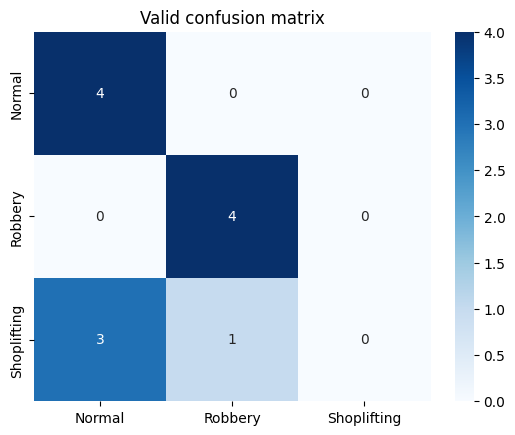

In [26]:
cm = metrics.confusion_matrix(y_true, y_pred)
ax = sn.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
ax.set_title('Valid confusion matrix')
plt.show()

Normal vs Anomalies

In [27]:
precisions = metrics.precision_score(y_true>0, y_pred>0)
print(f'Precision 2 classes: {precisions:.4f}')

recalls = metrics.recall_score(y_true>0, y_pred>0)
print(f'Recall 2 classes: {recalls:.4f}')

Precision 2 classes: 1.0000
Recall 2 classes: 0.6250


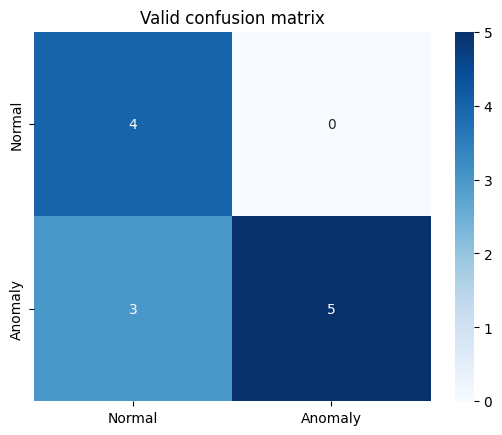

In [28]:
cm = metrics.confusion_matrix(y_true>0, y_pred>0)
ax = sn.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'] , yticklabels=['Normal', 'Anomaly']  )
ax.set_title('Valid confusion matrix')
plt.show()

## Inference

In [ ]:
!mkdir test
!mkdir output

In [29]:
input_video_path = 'test'    # path to test video
output_video_path = 'output' # path to the output results

In [30]:
transform_fn = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

net = get_model(name='slowfast_4x16_resnet50_custom', nclass=len(classes), num_segments=num_segments, pretrainded=False, pretrained_base=False, ctx=ctx)
net.load_parameters(f'{models_path}/slowfast_ucf_19.params', ctx=ctx)

In [31]:
anomaly_classes = ['Robbery', 'Shoplifting']

In [35]:
!rm -r /content/test/.ipynb_checkpoints/

In [36]:
def process_video(video_name, input_path, output_path, net, transform_fn, classes, num_frames=48, verbose=True):
    '''
    Classify action on each num_frames*num_segments length clip from video and write output video with classification result.

    Args:
        video_name: video name
        input_path: path to input folder
        output_path: path to output folder
        net: the net to perform classification
        transform_fn: a function that transforms data
        classes: list of actions can be detected on video
        num_frames: the length of input video clip
        verbose: verbosity level

    Returns:
        dict: Classification result for each segment.
    '''
    if verbose:
        print(f'Video: {video_name}')
    vr = decord.VideoReader(f'{input_video_path}/{video_name}')
    segments = split_on_segments(vr, net.num_segments*num_frames)
    anomaly_classes = list(filter(lambda c: c != 'Normal', classes))

    temp_output_path = f'{output_path}/{video_name}'
    if not os.path.exists(temp_output_path):
        os.mkdir(temp_output_path)

    video_data = None
    results = {}

    for i, segment in enumerate(segments):
        video_data = vr.get_batch(segment).asnumpy()
        start_time = time.time()
        pred_class, pred_class_prob = predict(net, video_data, transform_fn, num_frames, classes)
        end_time = time.time()
        results[i] = {'predicted_class': pred_class, 'probability':pred_class_prob}
        if pred_class in anomaly_classes:
            pred_class = 'Anomaly'
        add_result_on_clip(video_data, pred_class, pred_class_prob, anomaly_classes)
        write_video_output(f'{temp_output_path}/batch_{i:04d}.mp4', video_data)

        if verbose:
            print(f'[Segment: {i}] predicted_class: {pred_class}, probability: {pred_class_prob:.4f}, time: {end_time-start_time:0.1f} sec')

    if video_data is not None:
        height = video_data.shape[1]
        width = video_data.shape[2]
        merge_clips(temp_output_path, video_name, output_path, (width, height))
    shutil.rmtree(temp_output_path)

    return results

def split_on_segments(vr, segm_length=48, verbose=True):
    '''
    Split video on segments with *segm_length* length.
    Args:
        vr: decode.VideoReader
        segm_length: segment length
        verbose: verbosity level
    Returns:
        list: List of frame indexes, splitted on segments.
    '''
    n_frames = len(vr)
    fps = vr.get_avg_fps()
    duration = n_frames/fps
    all_idx = np.arange(n_frames)
    idx = range(0, len(all_idx), segm_length)

    segments = []
    for i in idx:
        segment = all_idx[i:i+segm_length]
        if len(segment) >= segm_length:
            segments.append(segment)

    if verbose:
        print(f'[Frames partitioning] total frames: {n_frames}, fps: {fps}, duration: {duration:.1f} sec, split on: {len(segments)} segments, segments length: {[i.shape[0] for i in segments]} frames')
    return segments

def predict(net, clip, transform_fn, num_frames, classes):
    '''
    Predict action on clip.

    Args:
        net: the net to perform classification
        clip: video clip for predicting action on it
        transform_fn: a function that transforms data
        num_frames: the length of input video clip
        classes: list of action that can be detected on video

    Returns:
        str, float: Class label with class probability.
    '''

    clip_input = transform_fn(clip)
    clip_input = np.stack(clip_input, axis=0)
    clip_input = clip_input.reshape((-1,) + (num_frames, 3, 224, 224))
    clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))

    pred = net(nd.array(clip_input).as_in_context(ctx[0]))
    ind = nd.topk(pred, k=1)[0].astype('int')
    pred_class = classes[ind[0].asscalar()]
    pred_class_prob = nd.softmax(pred)[0][ind[0]].asscalar()

    return pred_class, pred_class_prob

def add_result_on_clip(clip, pred_class, pred_class_prob, anomaly_classes):
    '''
    Add classification result on clip.

    Args:
        clip: video clip for adding classification results on it
        pred_class: predicted class
        pred_class_prob: probability of predicted action
        anomaly_classes: list of anomaly actions
    '''
    for frame in clip:
        draw_classification_result(frame, pred_class, pred_class_prob)
        if pred_class in anomaly_classes and pred_class_prob > 0.65:
            draw_alert_mark(frame)

def draw_alert_mark(frame):
    '''
    Add alert (triangle with "!" sign) to mark frame with anomaly.

    Args:
        frame: video frame
    '''

    pts = np.array([[165,15],[182,45],[148,45]])
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(frame,[pts],(255,0,0))
    cv2.putText(frame,"!",(160,42),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

def draw_classification_result(frame, class_name, prob):
    '''
    Add classification result on frame.

    Args:
        frame: video frame
        class_name: predicted class
        prob: probability of predicted class
    '''
    cv2.rectangle(frame, (8, 5), (190, 55), (240, 240, 240), cv2.FILLED)

    text_color = (0,0,0)
    cv2.putText(frame,f'class: {class_name}',(10,25),cv2.FONT_HERSHEY_SIMPLEX,0.4,text_color,1)
    cv2.putText(frame,f'probability: {prob:0.4f}',(10,45),cv2.FONT_HERSHEY_SIMPLEX,0.4,text_color,1)

def write_video_output(output_path, video_data):
    '''
    Write classified video to file.

    Args:
        output_path: path to output video file
        video_data: video data that should be saved to file
    '''

    if video_data is None:
        print(f'{output_path} can\'t write file.')
        return

    height = video_data.shape[1]
    width = video_data.shape[2]

    out = cv2.VideoWriter(f'{output_path}', cv2.VideoWriter_fourcc(*'MP4V'), 30.0, (width, height))

    for frame in video_data:
        out.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    out.release()

def merge_clips(clips_path, video_name, output_path, video_shape):
    '''
    Merge clips into one video.

    Args:
        clips_path: path to clips folder
        video_name: video name
        output_path: path to output folder
        video_shape: (width, height) shape of output video
    '''
    out = cv2.VideoWriter(f'{output_path}/output_{video_name}', cv2.VideoWriter_fourcc(*'MP4V'), 30.0, video_shape)
    clips_list = sorted(os.listdir(clips_path))
    for clip_name in clips_list:
        clip = cv2.VideoCapture(f'{clips_path}/{clip_name}')
        ret, frame = clip.read()
        while(ret):
            out.write(frame)
            ret, frame = clip.read()
        clip.release()

    out.release()


In [37]:
video_list = os.listdir(input_video_path)

for video_name in video_list:
    process_video(video_name, input_video_path, output_video_path, net, transform_fn, classes, num_frames=num_frames, verbose=1)

Video: Robbery012_x264.mp4
[Frames partitioning] total frames: 749, fps: 30.0, duration: 25.0 sec, split on: 3 segments, segments length: [192, 192, 192] frames
[Segment: 0] predicted_class: Anomaly, probability: 0.5547, time: 5.3 sec
[Segment: 1] predicted_class: Anomaly, probability: 0.6484, time: 0.7 sec
[Segment: 2] predicted_class: Anomaly, probability: 0.5271, time: 0.6 sec
Video: Shoplifting005_x264.mp4
[Frames partitioning] total frames: 1967, fps: 30.0, duration: 65.6 sec, split on: 10 segments, segments length: [192, 192, 192, 192, 192, 192, 192, 192, 192, 192] frames
[Segment: 0] predicted_class: Normal, probability: 0.6526, time: 0.9 sec
[Segment: 1] predicted_class: Normal, probability: 0.5159, time: 1.6 sec
[Segment: 2] predicted_class: Anomaly, probability: 0.5975, time: 0.9 sec
[Segment: 3] predicted_class: Anomaly, probability: 0.4357, time: 0.8 sec
[Segment: 4] predicted_class: Anomaly, probability: 0.6578, time: 0.7 sec
[Segment: 5] predicted_class: Anomaly, probabil

In [38]:
!cp -r /content/output /content/drive/MyDrive/Anomaly